In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
from sklearn.metrics import mean_squared_error
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from random import seed
import scipy.optimize as opt
plt.style.use("seaborn-darkgrid")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed(14092022)

In [3]:
# NOTA: fijar el seed SOLAMENTE si se estan probando diferentes modelos
# seed(2418)

# From now on we'll work with proportions instead of integer numbers
# i -> infectados/N
# Parameters: 
# beta = disease transmission rate
# gamma = recovery rate
# mu = mortality rate
# mu + beta = renewal rate
# theta = [beta - (mu+gamma), beta]
# Thus, if theta[0]<0, the disease will vanish and if theta[0]>0 we have persistence of the disease

i0 = 0.2 # initial proportion of infected
Tf = 20 # Terminal time
T0 = 0 # Initial time
Dt = 0.25 # time step
beta, gamma, mu = 0.7, .1, 0.3
theta= np.asarray([beta - (mu+gamma), beta])
theta_t= theta
times = np.arange(T0, Tf, Dt) # time vector

In [4]:
theta_t

array([0.3, 0.7])

In [5]:
# ODE model
def SIS(i, t, theta):
    di = theta[0]* i[0] - theta[1]* i[0]*i[0]
    return di

In [6]:
sis_model = DifferentialEquation(
    func=SIS,
    times = np.arange(T0, Tf, Dt),
    n_states=1,
    n_theta=2,
    t0=0,
)

In [7]:
# ODE solution (analytical solution computed before)
def solution_SIS(t,*param):
  aux_exp = np.exp(param[0]*t)
  aux = param[0] + param[1]*(i0)*(aux_exp - 1)
  return i0*param[0]*aux_exp/aux

In [8]:
# Create true ODE solution
infected_t = odeint(SIS, t=times, y0=i0, args=(theta,), rtol=1e-8)
# Simulate observations (true data+log-normal noise with parameter sigma=0.5 in this case)
infected_obs = np.random.lognormal(mean=np.log(infected_t[1::]), sigma=0.25)
# we add initial condition after because we now the exact initial condition (it doesn't have noise)
infected_obs = np.concatenate((np.asarray([[i0]]),infected_obs)) 

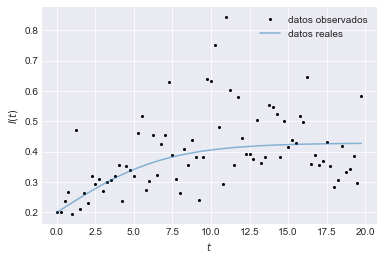

In [9]:
# Plot observations and true data
plt.plot(times, infected_obs, marker="o", linestyle="none", color='k', markersize=2, label=f"datos observados")
plt.plot(times, infected_t, color="C0", alpha=0.5,  label=f"datos reales")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.legend()
plt.show()

In [10]:
# REGRESION MODEL -------------------------------------------------------------
# This suppose to be our benchmark in the case of the deterministic model
theta0 = np.asarray([0.1, 0.1])#punto de partida para la busqueda del optimo
reg_estim, _ = opt.curve_fit(solution_SIS, xdata = times, p0=theta0, ydata = infected_obs.flatten(), maxfev=5000)     
print("\n Parámetros reales", theta_t)
print("\n Parámetros estimados con regresión", reg_estim)
reg_model = solution_SIS(times, *reg_estim) # curve obtained from regresion estimates


 Parámetros reales [0.3 0.7]

 Parámetros estimados con regresión [0.37122691 0.8324541 ]


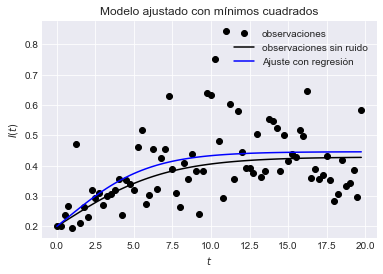

In [11]:
# COMPARE REGRESION MODEL VERSUS TRUE MODEL AND OBSERVATIONS-------------------
plt.plot(times, infected_obs.flatten(), "ko", label="observaciones")
plt.plot(times, infected_t.flatten(), "k-", label="observaciones sin ruido")
plt.plot(times, reg_model, "b-", label="Ajuste con regresión")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.title("Modelo ajustado con mínimos cuadrados")
plt.legend(loc="upper right")
plt.show()

In [12]:
# Define pymc model and sampling the MC Markov chain
nb_chains = 2 #choose >1 to run some convergence diagnostics on the chains
len_chains = 1500
len_burning_states = 1500

In [13]:
with pm.Model() as model4:
    # Define prior distributions
    noise_hiperparam = pm.HalfCauchy("noise_hiperparam", 1, shape=1) # noise hiperparameter
    # This prior does not assume a prior knowledge on the persistence or extintion of the disease
    # But if the user knows if the disease persists, the prior can be feed with more info on the support
    param = [0,0]
    param[0] = pm.Normal("beta-(mu+gamma)",0,1) 
    param[1] = pm.Bound(pm.Cauchy, lower=0)("beta", 1,1)
    # define output of the computational model
    sis_curves = sis_model(y0=[i0], theta=param)
    #Define statistical model for observations
    Y = pm.Lognormal("Y", mu=pm.math.log(sis_curves), sigma=noise_hiperparam, observed=infected_obs)
    trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains)
    data = az.from_pymc3(trace=trace)


C:\Users\sebas\AppData\Local\Temp\ipykernel_20172\3738376770.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, beta-(mu+gamma), noise_hiperparam]


c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 1443 seconds.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


The acceptance probability does not match the target. It is 0.8857207396428394, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6865640536908575, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [14]:
# CONVERGENCE DIAGNOSTICS -----------------------------------------------------
print("\n Parámetros reales", theta_t)
print("\n Resumen de los resultados para la cadena de Markov construida:")
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.



 Parámetros reales [0.3 0.7]

 Resumen de los resultados para la cadena de Markov construida:


c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta-(mu+gamma),0.410,0.092,0.259,0.583,0.005,0.003,340.0,640.0,1.0
noise_hiperparam[0],0.254,0.022,0.216,0.294,0.001,0.001,311.0,130.0,1.0
beta,0.966,0.241,0.589,1.438,0.013,0.009,341.0,571.0,1.0


Text(0, 0.5, 'MCMC promedio')

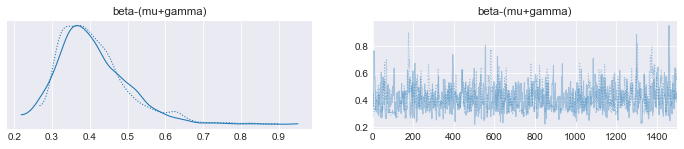

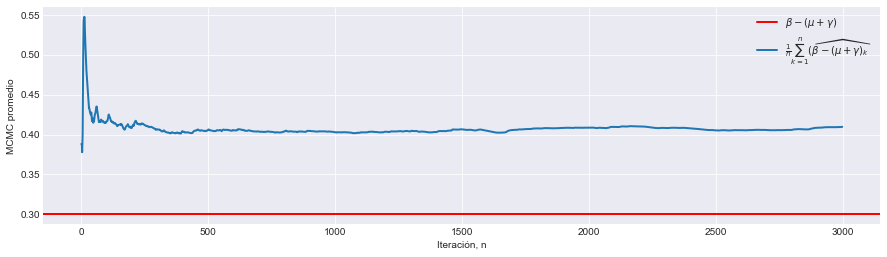

In [15]:
# plot the exploration for each chain and convergence of the ergodic mean
# beta - (mu+gamma)
az.plot_trace({"beta-(mu+gamma)": trace.get_values(varname="beta-(mu+gamma)", combine=False)})
mean_theta0 = [np.mean(trace['beta-(mu+gamma)'][:i]) for i in np.arange(1, len(trace['beta-(mu+gamma)']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[0]], lw=2, color="red", label=r"$\beta-(\mu+\gamma)$")
plt.plot(mean_theta0, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{(\beta-(\mu+\gamma)}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

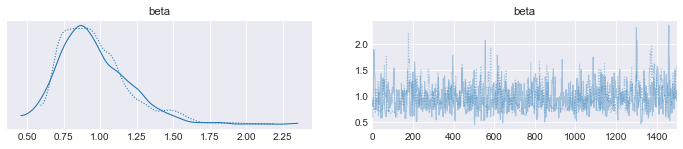

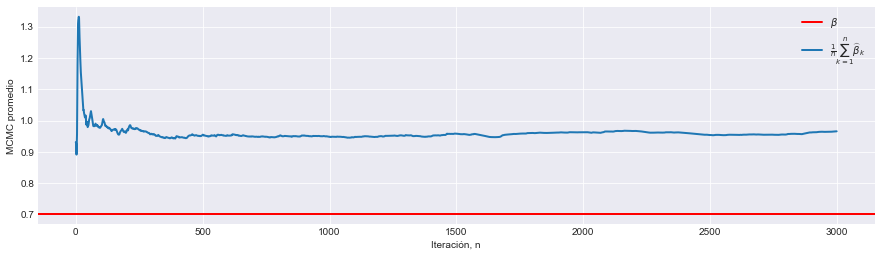

In [16]:
# beta
az.plot_trace({"beta": trace.get_values(varname="beta", combine=False)})
mean_theta1 = [np.mean(trace['beta'][:i]) for i in np.arange(1, len(trace['beta']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[1]], lw=2, color="red", label=r"$\beta$")
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\beta}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

In [17]:
# Rhat plots
# .
# .
# .
# .
# .
# .
# can we replicate the observations? (see pymc documentation to find function that allow sampling from posteriors)
# .
# .
# .
# .
# .
# .

In [18]:
# Define bayes model with Bayes estimators
MCMC_model = solution_SIS(times, mean_theta0[-1], mean_theta1[-1])

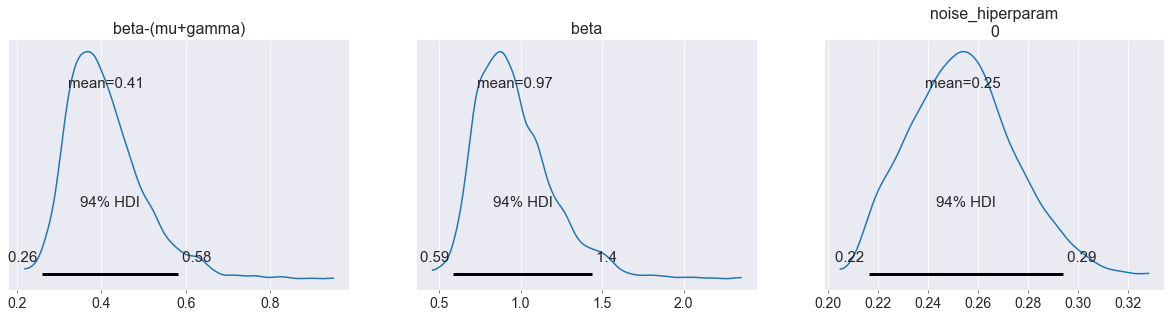

In [19]:
# Plot posterior densities
az.plot_posterior(data, 
                  var_names=["beta-(mu+gamma)", "beta", "noise_hiperparam"]);
plt.show()

In [20]:
# VALIDATION OF PYMC MODEL----------------------------------------------------    
print("\n Parámetros reales:", theta_t)
print("Parámetros estimados con regresión:", reg_estim)
print("Parámetros estimados con MCMC:", [mean_theta0[-1], mean_theta1[-1]])


 Parámetros reales: [0.3 0.7]
Parámetros estimados con regresión: [0.37122691 0.8324541 ]
Parámetros estimados con MCMC: [0.4096617070118464, 0.9655279496564908]


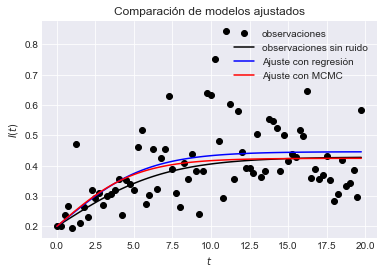

In [21]:
# COMPARE MODELS -------------------
plt.plot(times, infected_obs.flatten(), "ko", label="observaciones")
plt.plot(times, infected_t.flatten(), "k-", label="observaciones sin ruido")
plt.plot(times, reg_model, "b-", label="Ajuste con regresión")
plt.plot(times, MCMC_model, "r-", label="Ajuste con MCMC")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.title("Comparación de modelos ajustados")
plt.legend(loc="upper right")
plt.show()


In [22]:
#MSE with respect to observed data
print("\n Error cuadrático medio para regresión:",mean_squared_error(infected_obs, reg_model))
print("Error cuadrático medio para MCMC:",mean_squared_error(infected_obs, MCMC_model))



 Error cuadrático medio para regresión: 0.011887747629275403
Error cuadrático medio para MCMC: 0.012128083525096834


In [23]:
#MSE with respect to true data
print("\n Error cuadrático medio para regresión:",mean_squared_error(infected_t, reg_model))
print("Error cuadrático medio para MCMC:",mean_squared_error(infected_t, MCMC_model))



 Error cuadrático medio para regresión: 0.0005994927710123927
Error cuadrático medio para MCMC: 0.0002520639689176395


In [24]:
RANDOM_SEED = 58

In [25]:
with model4:
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED,samples=10000)

<AxesSubplot:xlabel='Y / Y'>

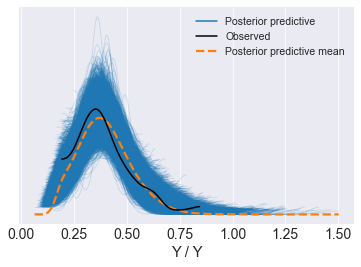

In [26]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model4))

In [27]:
az.summary(ppc)

c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\base.py:220: UserWarning: More chains (10000) than draws (80). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Y[0],0.396,0.123,0.172,0.62,0.0,0.0,82976.0,224424.0,1.07


c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\base.py:220: UserWarning: More chains (10000) than draws (80). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


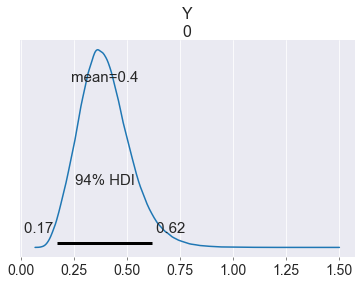

In [28]:
az.plot_posterior(ppc);
plt.show()